In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Lets check your GPU
if tf.config.list_logical_devices('GPU') != []:
    print("LET'S DO THISS!!! :DDDD")
else: 
    print("Oh dude... D:")

LET'S DO THISS!!! :DDDD


In [ ]:
with open('data/input.txt') as f:
    content = f.read().lower()

In [ ]:
print(content[:100])

first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.

first citizen:
you


In [ ]:
"".join(sorted(set(content.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [ ]:
text_vec_layer = keras.layers.TextVectorization(
                                                split="character",
                                                standardize="lower"
                                            )
text_vec_layer.adapt([content])
encoded = text_vec_layer([content])[0]

In [ ]:
encoded -= 2  # drop tokens 0 (pad) and 1 (unknown), subtraindo 2 (pad e unknown)
n_tokens = text_vec_layer.vocabulary_size() - 2  # number of distinct chars = 39
dataset_size = len(encoded)  # total number of chars = 1,115,394

In [ ]:
encoded

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19,  5,  8, ..., 20, 26, 10], dtype=int64)>

In [ ]:
n_tokens, dataset_size

(39, 1115394)

In [ ]:
window_size = 128
batch_size = 32
ds = tf.data.Dataset.from_tensor_slices(encoded) # Fatia o ds em janelas de tamanho window_size
ds = ds.window(window_size + 1, shift=1, drop_remainder=True) # Você pode visualizar com um .as_numpy_iterator() e colocar num loop com .take(1)
ds = ds.flat_map(lambda window: window.batch(window_size + 1)) # Transforma cada janela em um tensor
ds = ds.shuffle(100_000, seed=42)
ds = ds.batch(batch_size)
ds = ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

In [ ]:
for X_batch, y_batch in ds.take(1):
    print(X_batch.shape, y_batch.shape)
    print(X_batch[0], y_batch[0])

(32, 128) (32, 128)
tf.Tensor(
[ 9 12  0 19  5 20  6  2  0 16  5  2  6  0  2 27  3  2  6  1  8 17 10  1
  8  1  0  7  2  4 15  0 21  1  6  5  9 12  0  2  6  5  7  0 21 13  7  5
  9  1  7  7 26 10 10 14  1  9  1  9  5 13  7 23 10  3 17  0  2  8 13  1
 31 21  8  1 12 30 10 10 19  5  8  7  2  0  7  1  9  4  2  3  8 23 10 15
  3 13  8  0 18  3 14 22  4  9 15  0  2  3  0  2  6  1  0 18  4 22  5  2
  3 11 28  0 16  6  1  8], shape=(128,), dtype=int64) tf.Tensor(
[12  0 19  5 20  6  2  0 16  5  2  6  0  2 27  3  2  6  1  8 17 10  1  8
  1  0  7  2  4 15  0 21  1  6  5  9 12  0  2  6  5  7  0 21 13  7  5  9
  1  7  7 26 10 10 14  1  9  1  9  5 13  7 23 10  3 17  0  2  8 13  1 31
 21  8  1 12 30 10 10 19  5  8  7  2  0  7  1  9  4  2  3  8 23 10 15  3
 13  8  0 18  3 14 22  4  9 15  0  2  3  0  2  6  1  0 18  4 22  5  2  3
 11 28  0 16  6  1  8  1], shape=(128,), dtype=int64)


In [ ]:
# Criando função
def to_dataset(sequence, window_size=128, batch_size=32, seed=42, shuffle=False, target='all_window'):
    ds = tf.data.Dataset.from_tensor_slices(sequence) # Fatia o ds em janelas de tamanho window_size
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True) # Você pode visualizar com um .as_numpy_iterator() e colocar num loop com .take(1)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1)) # Transforma cada janela em um tensor
    if shuffle:
        ds = ds.shuffle(100_000, seed=seed)
    ds = ds.batch(batch_size)
    if target == 'all_window':
        ds = ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)
    elif target == 'last_char':
        ds = ds.map(lambda window: (window[:, :-1], window[:, -1])).prefetch(1)
    else:
        raise ValueError('target must be "all_window" or "last_char"')
    return ds

In [ ]:
# Exemplo de uso
list(to_dataset(text_vec_layer(['To be'])[0], window_size=3))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[ 4,  5,  2],
         [ 5,  2, 23]], dtype=int64)>,
  <tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[ 5,  2, 23],
         [ 2, 23,  3]], dtype=int64)>)]

In [ ]:
window_size = 128
tf.random.set_seed(42)
train_set = to_dataset(encoded[:1_000_000], window_size=window_size, shuffle=True, seed=42)
valid_set = to_dataset(encoded[1_000_000:1_060_000], window_size=window_size)
test_set = to_dataset(encoded[1_060_000:], window_size=window_size)

### Training Char-RNN model

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

In [ ]:
def decoder(seq):
    output = np.array(text_vec_layer.get_vocabulary())[seq + 2]
    new_output = []
    for i in range(output.shape[0]):
        phrase = ""
        for j in range(output.shape[1]):
            phrase += output[i, j]
        new_output.append(phrase)
    return np.array(new_output)

In [ ]:
# estilo
plt.style.use('dark_background')
plt.rcParams['axes.facecolor'] = '#26262e' 

def print_multiple_generated(predicted_text, original_text, n=8):
    print("--> Original text:")
    for i in range(n):
        print(original_text[i])
    print("\n--> Generated text:")
    for i in range(n):
        print(predicted_text[i])
        
def plot_loss(history, step):
    plt.plot(list(range(len(history['loss']))), history['loss'], label='Training Loss')
    plt.plot(list(range(len(history['loss']))), history['val_loss'], label='Validation Loss')
    plt.xlabel('Step')
    plt.ylabel('Loss')


--> Original text:
 not to save labour, nor that i want love.

valeria:
you would be another penelope: yet, they say, all
the yarn she spun in ulys

--> Generated text:
tg nbbnrpa:garwgwtw aw .ratpt..:wb.r..p


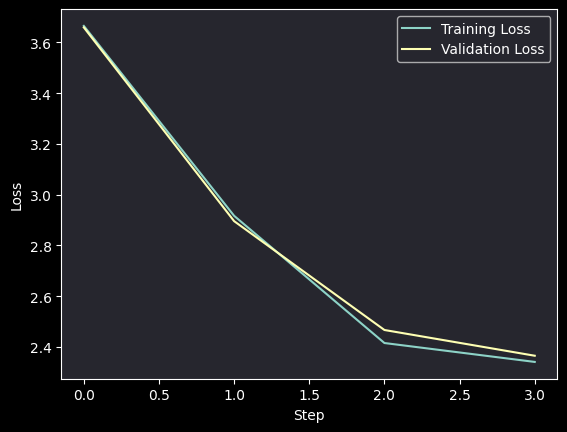

In [ ]:
from IPython.display import clear_output

history = {
            'loss': [],
            'val_loss': []
        }

sparse_categorical_crossentropy = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.Nadam()
n_epochs = 10
step = 0

for epoch in range(n_epochs):
    n_batch = 0
    for X_batch, y_batch in train_set:
        
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            loss = sparse_categorical_crossentropy(y_batch, y_pred)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        if step % 100 == 0:
    
            y_proba_ = model(X_batch)
            y_pred_ = tf.argmax(y_proba_)  # choose the most probable character ID
            predicted_text = decoder(y_pred_)
            original_text = decoder(X_batch)
                        
            # Val loss
            
            val_loss = 0
            n_val_batch = 0
            for X_val, y_val in valid_set:
                y_proba_val = model(X_val)
                val_loss += sparse_categorical_crossentropy(y_val, y_proba_val)
                n_val_batch += 1
                if n_val_batch == 100:
                    break
            val_loss /= n_val_batch
            
            history['loss'].append(loss.numpy())
            history['val_loss'].append(val_loss.numpy())
                  
            clear_output()
            
            print_multiple_generated(predicted_text, original_text, 1)
            plot_loss(history, step)
            plt.legend()
            plt.show()
            
        n_batch += 1
        step += 1
        

In [ ]:
# y_proba_ = model(X_batch)
# y_pred_ = tf.argmax(y_proba_, axis=-1)
# decoder(y_pred_)[:10]

array(['e  nn o iie   ai    inn  ee   e o oe i e        o nnee  n   ieeiee        e o     nnne   ieeieiee  e  ie i ne iiie ii  een  ieie',
       'oee a  oo ee   i ii  i  e e i inne nnno nnin i e i i    e   iiiei e   e  a a nee ieeee   nnnnn  iin i iie enee i iieei  ni i iei',
       'ei  nneeeee  niiii nnn i ii n  ie ii   e i iiii i   i   ea i  oi i   e aoa   ioeeoe     i eie   i   e  i i  ie ani ianeineiniei ',
       'ieeiiii  i i e ne o i a o  eeeeienineeeeneeeee  nnn ieeie       ee e   in i iee ie iiinneon         a e nn in iie  ieeeeeee i  e',
       'iinn  iiie     ee   eaa i i i  i i  i  n oi i eae ii n iieieee    o   i  ineeeiiieeie a     ie ieeio nnen e   n  o   e o eeeee o',
       'aeea    e   nnnn ie a  e o   iei i neiee  i i i  e e   ieii      ioonnn io   i n ni i  e  neeie a  oo ee   i ii  i  e e i inne n',
       'i ii  ieei iii  eo   e i  nen nninn   e  eeei n i  ieee i  i  e oeo e  i  iiii e   n       n i   aa i  i  eii  eniii     ii ee e',
       'oe i ii iieiee o e 

In [ ]:

# y_pred_ = tf.argmax(y_proba_)  # choose the most probable character ID
# len(decoder(y_pred_)[0])